## Задача 4. Ансамбли

Ершов Александр Сергеевич, гр. 22.М04-мм

Задача:

\+ Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.

\+ Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.

\+ Самостоятельно реализуйте алгоритмы Bagging и AdaBoost, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из sklearn (Bagging, Random Forest, AdaBoost, Gradient Tree Boosting, Histogram-Based Gradient Boosting).

\+ При обучении использовать подбор гиперпараметров, кросс-валидацию.

\+ Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.

\+ * (+2 балла) Также добавить в сравнение модели из библиотек Xgboost, LightGBM и CatBoost.

\+ * (+3 балла) Для подбора гиперпараметров использовать фреймворк Optuna.

### Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.

Датасет "Airlines Delay. Can you predict when a flight in delayed?" https://www.kaggle.com/datasets/ulrikthygepedersen/airlines-delay.


In [ ]:
import pandas as pd
data = pd.read_csv("data.csv")
data.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


Описание датасета:
- Flight - номер рейса
- Time - время вылета по расписанию
- Length - длительность задержки
- Airline - авиакомпания
- AirportFrom - аэропорт вылета
- AirportTo - аэропорт прилета
- DayOfWeek - день недели
- Class - класс рейса, целевой признак

### Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539382 entries, 0 to 539381
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Flight       539382 non-null  float64
 1   Time         539382 non-null  float64
 2   Length       539382 non-null  float64
 3   Airline      539382 non-null  object 
 4   AirportFrom  539382 non-null  object 
 5   AirportTo    539382 non-null  object 
 6   DayOfWeek    539382 non-null  int64  
 7   Class        539382 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 32.9+ MB


В датасете 539382 строки и 8 признаков.

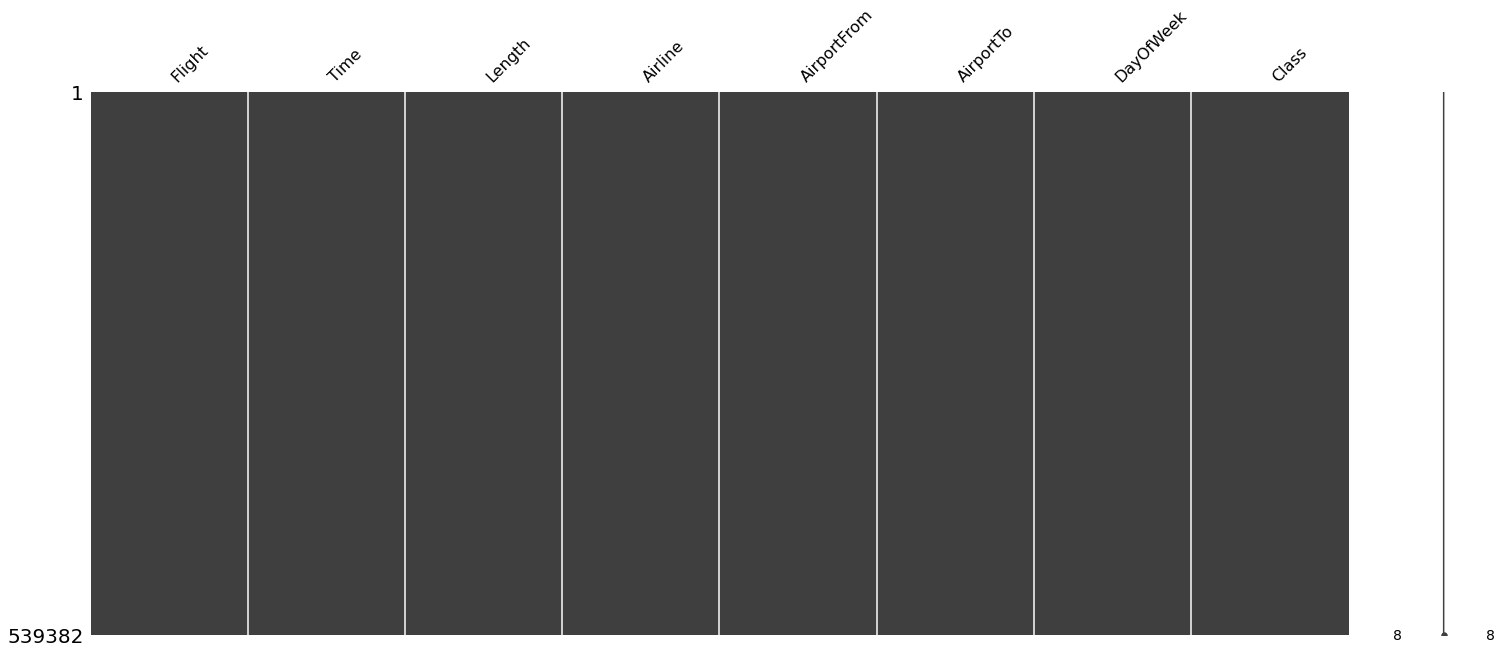

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data)
plt.show()

In [ ]:
data.isnull().sum()

Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

Пропусков в данных нет.

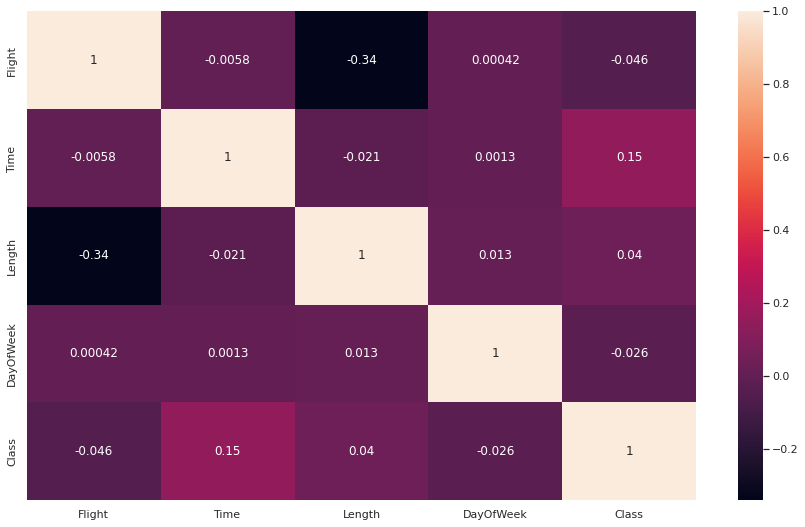

In [ ]:
import seaborn as sns
sns.set (rc = {'figure.figsize':(15, 9)})
sns.heatmap(data.corr(), annot = True)
plt.show ()

Сильной корреляции признаков не найдено.

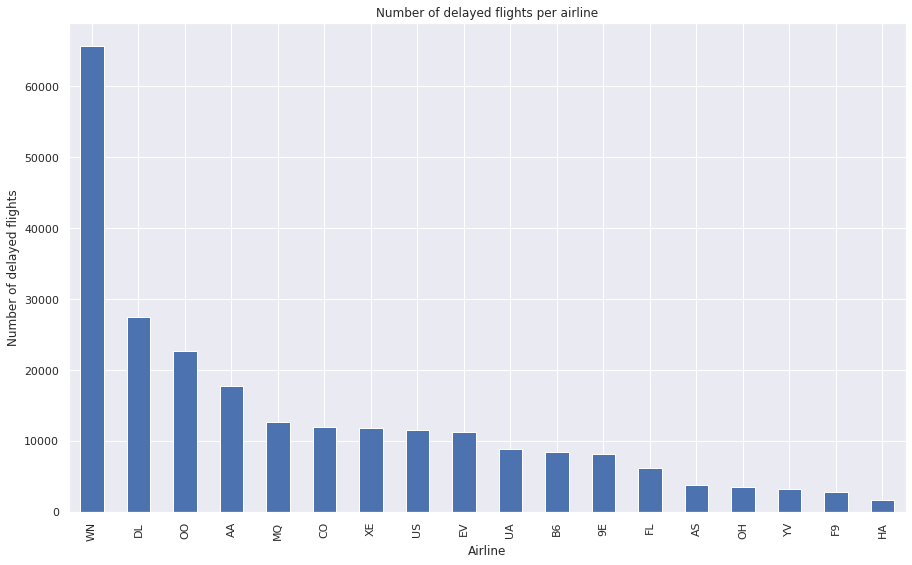

In [ ]:
c = data.groupby('Airline').sum()['Class'].sort_values(ascending=False)
c.plot(kind='bar')
plt.ylabel('Number of delayed flights')
plt.title('Number of delayed flights per airline')
plt.show()

У авиакомпании WN наибольшее количество задержанных рейсов.

[Text(0.5, 1.0, 'Number of flights by firline')]

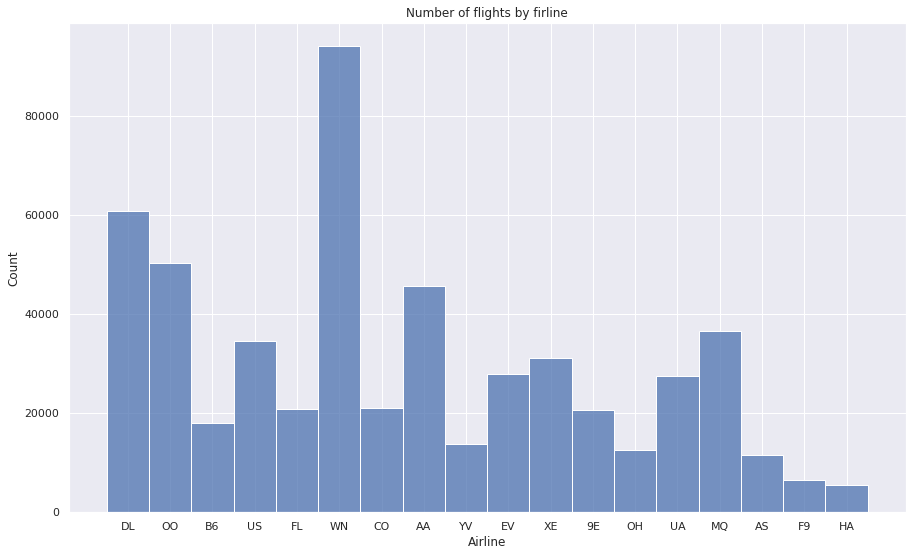

In [ ]:
import seaborn as sns
sns.histplot(data=data, x="Airline").set(title='Number of flights by firline')

Однако у авиакомпании WN также наибольшее число рейсов.

[Text(0.5, 1.0, 'On-time and delayed flights by airline')]

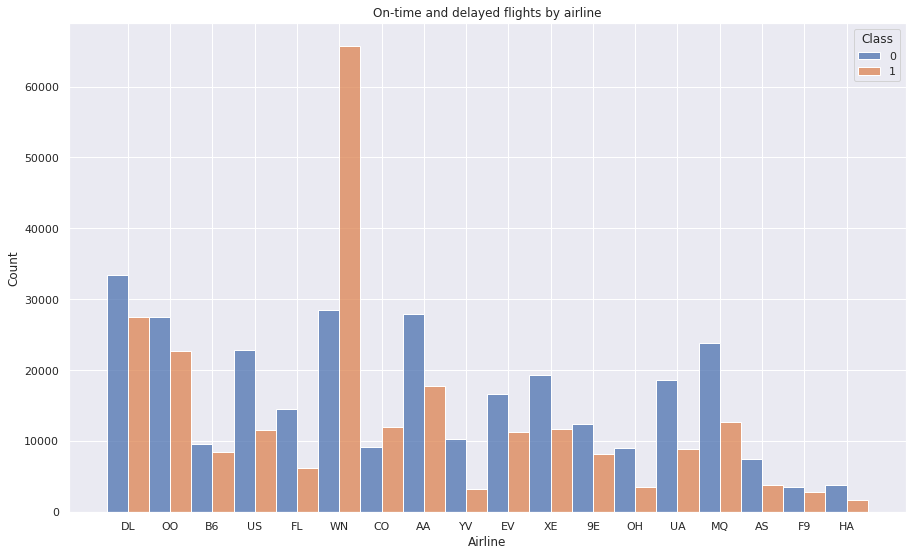

In [ ]:
sns.histplot(data=data, x="Airline",
             multiple="dodge",
             hue="Class").set(title='On-time and delayed flights by airline')

Разбивка по классам рейса даёт схожий с предыдущими результат.

<Axes: xlabel='DayOfWeek', ylabel='count'>

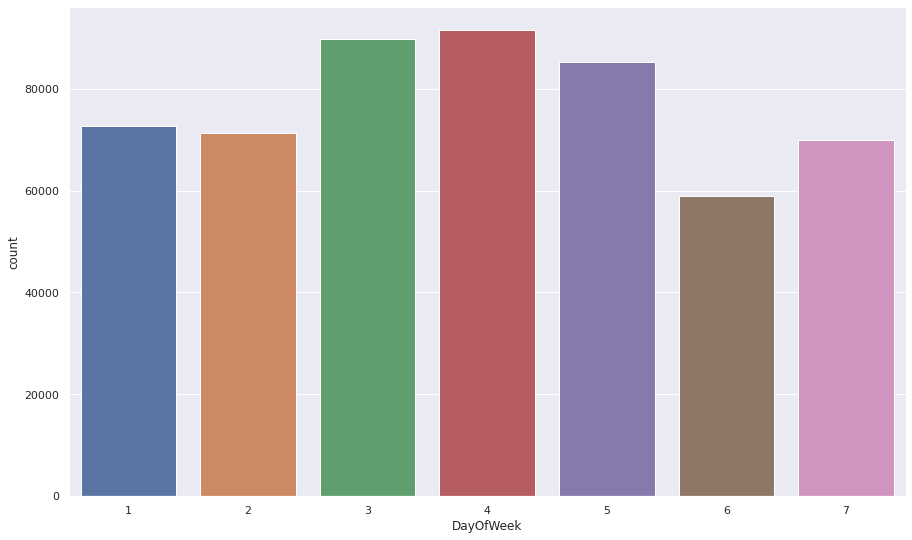

In [ ]:
sns.countplot(data=data, x="DayOfWeek")

Задержки рейсов чаще всего происходили в дни недели 3, 4, 5.

Преобразуем количественные признаки `Flight`, `Time`, `Length` в категориальные, разделив значения на 7 приблизительно равных групп с помощью `qcut()` из Pandas.

In [ ]:
data.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [ ]:
bin_labels = ['0', '1', '2', '3', '4', '5', '6']
data['Flight'] = pd.qcut(data['Flight'], q=7, precision=0, labels=bin_labels)
data['Time'] = pd.qcut(data['Time'], q=7, precision=0, labels=bin_labels)
data['Length'] = pd.qcut(data['Length'], q=7, precision=0, labels=bin_labels)

Закодируем коды авиакомпании, аэропортов вылета и прилета.

In [ ]:
from sklearn.preprocessing import LabelEncoder
data[['Airline','AirportFrom','AirportTo']] = data[['Airline','AirportFrom','AirportTo']].apply(LabelEncoder().fit_transform)

In [ ]:
data.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,4,6,4,5,16,129,1,0
1,6,0,4,12,65,208,4,0
2,2,6,4,3,35,60,3,0
3,0,6,6,14,203,217,6,0
4,1,2,2,8,32,16,4,0


Соберем данные для обучения.

In [ ]:
x = data.drop('Class', axis = 1).values
y = data['Class'].values

Разделим выборку на обучающую и тестовую.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=19)

### Самостоятельно реализуйте алгоритмы Bagging и AdaBoost, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений. Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из sklearn (Bagging, Random Forest, AdaBoost, Gradient Tree Boosting, Histogram-Based Gradient Boosting).

Реализация Bagging - MyBaggingDt

In [37]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class MyBaggingDt:
    def __init__(self, est_count = 15, samples_count = 1):
        self.est_count = est_count
        self.samples_count = samples_count

    def fit(self, x, y):
        self.est = []
        
        for i in range(self.est_count):
            sample_index = np.random.choice(self.samples_count, size = len(x))
            x_i = x[sample_index]
            y_i = y[sample_index]
            estimator = DecisionTreeClassifier()
            estimator.fit(x_i, y_i)
            self.est.append(estimator)

    def predict(self, x):
        prediction = np.zeros(len(x))
        for estimator in self.est:
            prediction += estimator.predict(x)
            
        return np.round(prediction / self.est_count)

Реализация AdaBoost - MyAdaBoostDt

In [ ]:
class MyAdaBoostDt:
    def __init__(self, est_count = 50, learning_rate = 1):
        self.est_count = est_count
        self.learning_rate = learning_rate
        self.est = []
        self.weights = np.zeros(est_count)

    def fit(self, x, y):
        w = (np.ones(len(x))) / len(x)
        
        for i in range(self.est_count):
            estimator = DecisionTreeClassifier()
            estimator.fit(x, y, sample_weight = w)
            error, incorrect = self.compute_error(x, y, w, estimator)
            
            weight = self.compute_weight(error, self.learning_rate)
            self.weights[i] = weight

            w *= np.exp(weight * incorrect * ((w > 0) | (weight < 0)))
            w /= np.sum(w)

            self.est.append(estimator)
            
    def compute_error(self, x, y, w, estimator):
        y_pred = estimator.predict(x)
        incorrect = (y_pred != y)
        estimator_error = np.sum(w[incorrect])
        
        return (estimator_error, incorrect)
    
    def compute_weight(self, error, learning_rate):
        return 1 if error <= 0 else learning_rate * np.log((1 - error) / error)

    def get_params(self, deep=True):
        return {'n_est': self.est_count, 'learning_rate': self.learning_rate}

    def predict(self, x):
        y_pred = np.zeros(len(x))
        for i, estimator in enumerate(self.est):
            y_pred += self.weights[i] * estimator.predict(x)
            
        return np.sign(y_pred)

#### Обучение ансамблей с подбором гиперпараметров с использованием фреймворка Optuna.

#### Реализации Bagging и AdaBoost

MyBaggingDt

In [ ]:
#!pip install --quiet optuna

In [38]:
from sklearn.metrics import accuracy_score
import time
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

n_trials = 22

def objective(trial):
    est_count = trial.suggest_int('Estimators count', 1, 25)
    samples_count = trial.suggest_int('Samples number', 1, 20)
    
    model = MyBaggingDt(est_count, samples_count)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

est_count_best = study.best_trial.params['Estimators count']
samples_count_best = study.best_trial.params['Samples number']

model = MyBaggingDt(est_count_best, samples_count_best)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

bagging_pred = model.predict(x_test)
bagging_accuracy = accuracy_score(y_test, bagging_pred)
bagging_time = end - start

print(f'Accuracy {bagging_accuracy}')
print(f'Time {bagging_time}')

Optuna: parameters {'Estimators count': 20, 'Samples number': 1}
Optuna: accuracy 0.5533726786762662
Accuracy 0.5533726786762662
Time 6.713970184326172


MyAdaBoostDt

In [ ]:
def objective(trial):
    est_count = trial.suggest_int('Estimators count', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    
    model = MyAdaBoostDt(est_count, learning_rate / 10)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

est_count_best = study.best_trial.params['Estimators count']
learning_rate_best = study.best_trial.params['Learning rate']

model = MyAdaBoostDt(est_count_best, learning_rate_best)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

adaboost_pred = model.predict(x_test)
adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
adaboost_time = end - start

print(f'Accuracy {adaboost_accuracy}')
print(f'Time {adaboost_time}')

Optuna: parameters {'Estimators count': 1, 'Learning rate': 3}
Optuna: accuracy 0.6087816333467231
Accuracy 0.6086580354108087
Time 2.824287176132202


#### Библиотечные модели

Sklearn - Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

def objective(trial):
    est_count = trial.suggest_int('Estimators number', 1, 25)
    samples_count = trial.suggest_int('Samples number', 1, 20)
    features_count = trial.suggest_int('Features number', 2, 10)
    model = BaggingClassifier(
        n_estimators = est_count,
        max_samples = samples_count / 20,
        max_features = features_count / 10,
        estimator = DecisionTreeClassifier())
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

est_count_best = study.best_trial.params['Estimators number']
samples_count_best = study.best_trial.params['Samples number']
features_count_best = study.best_trial.params['Features number']

model = BaggingClassifier(
    n_estimators = est_count_best,
    max_samples = samples_count_best / 20,
    max_features = features_count_best / 12,
    estimator = DecisionTreeClassifier())

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_bagging_pred = model.predict(x_test)
sklearn_bagging_accuracy = accuracy_score(y_test, sklearn_bagging_pred)
sklearn_bagging_time = end - start

print(f'Accuracy {sklearn_bagging_accuracy}')
print(f'Time {sklearn_bagging_time}')

Optuna: parameters {'Estimators number': 17, 'Samples number': 12, 'Features number': 7}
Optuna: accuracy 0.6599264592281309
Accuracy 0.6437104100361524
Time 11.498838663101196


Sklearn - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    est_count = trial.suggest_int('Estimators number', 1, 100)
    samples_count = trial.suggest_int('Samples number', 1, 20)
    features_count = trial.suggest_int('Features number', 2, 10)
    rfc = RandomForestClassifier(
        n_estimators = est_count,
        max_samples = samples_count / 20,
        max_features = features_count / 10,
        max_depth = 4,
        random_state = 19)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

est_count_best = study.best_trial.params['Estimators number']
samples_count_best = study.best_trial.params['Samples number']
features_count_best = study.best_trial.params['Features number']

model = RandomForestClassifier(
    n_estimators = est_count_best,
    max_samples = samples_count_best / 20,
    max_features = features_count_best / 10,
    max_depth = 4,
    random_state = 19)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_rfc_pred = model.predict(x_test)
sklearn_rfc_accuracy = accuracy_score(y_test, sklearn_rfc_pred)
sklearn_rfc_time = end - start

print(f'Accuracy {sklearn_rfc_accuracy}')
print(f'Time {sklearn_rfc_time}')

Optuna: parameters {'Estimators number': 58, 'Samples number': 4, 'Features number': 9}
Optuna: accuracy 0.6355653060593888
Accuracy 0.6355653060593888
Time 9.289645671844482


Sklearn - AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

def objective(trial):
    est_count = trial.suggest_int('Estimators number', 1, 10)
    learning_rate = trial.suggest_int('Learning rate', 1, 5)
    
    model = AdaBoostClassifier(
        n_estimators = est_count,
        learning_rate = learning_rate / 10,
        estimator = DecisionTreeClassifier())
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

est_count_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']

model = AdaBoostClassifier(
    n_estimators = est_count_best,
    learning_rate = learning_rate_best / 10,
    estimator = DecisionTreeClassifier())

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_adaboost_pred = model.predict(x_test)
sklearn_adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
sklearn_adaboost_time = end - start

print(f'Accuracy {sklearn_adaboost_accuracy}')
print(f'Time {sklearn_adaboost_time}')

Optuna: parameters {'Estimators number': 3, 'Learning rate': 1}
Optuna: accuracy 0.611241232271421
Accuracy 0.6086580354108087
Time 9.61298155784607


Sklearn - Gradient Tree Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):
    estimators_count = trial.suggest_int('Estimators number', 1, 25)
    depth = trial.suggest_int('Depth', 1, 10)
    features_count = trial.suggest_int('Features number', 2, 10)
    gbc = GradientBoostingClassifier(
        n_estimators = estimators_count,
        max_depth = depth,
        max_features = features_count / 10,
        random_state = 19)
    
    gbc.fit(x_train, y_train)
    y_pred = gbc.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

estimators_count_best = study.best_trial.params['Estimators number']
depth_best = study.best_trial.params['Depth']
features_count_best = study.best_trial.params['Features number']

model = GradientBoostingClassifier(
    n_estimators = estimators_count_best,
    max_depth = depth_best,
    max_features = features_count_best / 10,
    random_state = 19)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_gbc_pred = model.predict(x_test)
sklearn_gbc_accuracy = accuracy_score(y_test, sklearn_gbc_pred)
sklearn_gbc_time = end - start

print(f'Accuracy {sklearn_gbc_accuracy}')
print(f'Time {sklearn_gbc_time}')

Optuna: parameters {'Estimators number': 22, 'Depth': 10, 'Features number': 8}
Optuna: accuracy 0.6592157710966227
Accuracy 0.6592157710966227
Time 33.59503126144409


Sklearn - Histogram-Based Gradient Boosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial):
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    iter_count = trial.suggest_int('Iterations number', 1, 15)
    leaf_nodes_count = trial.suggest_int('Leaf nodes number', 2, 30)
    depth = trial.suggest_int('Depth', 1, 10)
    hgbc = HistGradientBoostingClassifier(
        learning_rate = learning_rate / 10,
        max_iter = iter_count,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes_count,
        random_state = 19)
    
    hgbc.fit(x_train, y_train)
    y_pred = hgbc.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

learning_rate_best = study.best_trial.params['Learning rate']
iter_count_best = study.best_trial.params['Iterations number']
depth_best = study.best_trial.params['Depth']
leaf_nodes_count_best = study.best_trial.params['Leaf nodes number']

model = HistGradientBoostingClassifier(
    learning_rate = learning_rate_best / 10,
    max_iter = iter_count_best,
    max_depth = depth_best,
    max_leaf_nodes = leaf_nodes_count_best,
    random_state = 19)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

sklearn_hgbc_pred = model.predict(x_test)
sklearn_hgbc_accuracy = accuracy_score(y_test, sklearn_hgbc_pred)
sklearn_hgbc_time = end - start

print(f'Accuracy {sklearn_hgbc_accuracy}')
print(f'Time {sklearn_hgbc_time}')

Optuna: parameters {'Learning rate': 6, 'Iterations number': 14, 'Leaf nodes number': 27, 'Depth': 9}
Optuna: accuracy 0.6536724036708587
Accuracy 0.6536724036708587
Time 2.869513750076294


XGBoost - XGBClassifier

In [ ]:
from xgboost import XGBClassifier

def objective(trial):
    est_count = trial.suggest_int('Estimators number', 1, 25)
    leaves_number = trial.suggest_int('Leaves number', 1, 20)
    depth = trial.suggest_int('Depth', 1, 10)
    xgbc = XGBClassifier(
        n_estimators = est_count,
        max_leaves = leaves_number,
        max_depth = depth,
        random_state = 19)
    
    xgbc.fit(x_train, y_train)
    y_pred = xgbc.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

est_count_best = study.best_trial.params['Estimators number']
leaves_number_best = study.best_trial.params['Leaves number']
depth_best = study.best_trial.params['Depth']

model = XGBClassifier(
    n_estimators = est_count_best,
    max_leaves = leaves_number_best,
    max_depth = depth_best,
    random_state = 19)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

xgbc_pred = model.predict(x_test)
xgbc_accuracy = accuracy_score(y_test, xgbc_pred)
xgbc_time = end - start

print(f'Accuracy {xgbc_accuracy}')
print(f'Time {xgbc_time}')

Optuna: parameters {'Estimators number': 25, 'Leaves number': 18, 'Depth': 10}
Optuna: accuracy 0.6645428421345364
Accuracy 0.6645428421345364
Time 15.019673824310303


LightGBM - LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

def objective(trial):
    est_count = trial.suggest_int('Estimators number', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    depth = trial.suggest_int('Depth', 1, 10)
    lgbmc = LGBMClassifier(
        n_estimators = est_count,
        learning_rate = learning_rate / 10,
        max_depth = depth,
        random_state = 19)
    
    lgbmc.fit(x_train, y_train)
    y_pred = lgbmc.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Optuna: parameters {study.best_trial.params}')
print(f'Optuna: accuracy {study.best_value}')

est_count_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']
depth_best = study.best_trial.params['Depth']

model = LGBMClassifier(
    n_estimators = est_count_best,
    learning_rate = learning_rate_best / 10,
    max_depth = depth_best,
    random_state = 19)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

lgbmc_pred = model.predict(x_test)
lgbmc_accuracy = accuracy_score(y_test, lgbmc_pred)
lgbmc_time = end - start

print(f'Accuracy {lgbmc_accuracy}')
print(f'Time {lgbmc_time}')

Optuna: parameters {'Estimators number': 25, 'Learning rate': 7, 'Depth': 8}
Optuna: accuracy 0.6572382041219912
Accuracy 0.6572382041219912
Time 1.1314315795898438


CatBoost - CatBoostClassifier

In [ ]:
#!pip install catboost --quiet

In [ ]:
from catboost import CatBoostClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    depth = trial.suggest_int('Depth', 1, 10)
    cbc = CatBoostClassifier(
        n_estimators = estimators_number,
        learning_rate = learning_rate / 10,
        max_depth = depth,
        random_state = 42,
        verbose = False)
    
    cbc.fit(x_train, y_train)
    y_pred = cbc.predict(x_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']
depth_best = study.best_trial.params['Depth']

model = CatBoostClassifier(
    n_estimators = estimators_number_best,
    learning_rate = learning_rate_best / 10,
    max_depth = depth_best,
    random_state = 42,
    verbose = False)

start = time.time()
model.fit(x_train, y_train)
end = time.time()

cbc_pred = model.predict(x_test)
cbc_accuracy = accuracy_score(y_test, cbc_pred)
cbc_time = end - start

print(f'Accuracy {cbc_accuracy}')
print(f'Time {cbc_time}')

Best parameters: {'Estimators number': 22, 'Learning rate': 7, 'Depth': 10}
Best accuracy: 0.6556376108518988
Accuracy 0.6556376108518988
Time 2.8980298042297363


### Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.

In [39]:
metrics_summary = {
    'Accuracy': [bagging_accuracy, adaboost_accuracy, sklearn_bagging_accuracy,
                 sklearn_rfc_accuracy, sklearn_adaboost_accuracy,
                 sklearn_gbc_accuracy, sklearn_hgbc_accuracy, xgbc_accuracy,
                 lgbmc_accuracy, cbc_accuracy],
    'Time': [bagging_time, adaboost_time, sklearn_bagging_time,
             sklearn_rfc_time, sklearn_adaboost_time, 
             sklearn_gbc_time, sklearn_hgbc_time, xgbc_time, lgbmc_time, cbc_time]
}

models = [
    'MyBaggingDt', 'MyAdaBoostDt', 'Sklearn - Bagging',  
    'Sklearn - Random Forest', 'Sklearn - AdaBoost',
    'Sklearn - Gradient Tree Boosting', 'Sklearn - Histogram-Based Gradient Boosting',
    'XGBoost - XGBClassifier', 'LightGBM - LGBMClassifier', 'CatBoost - CatBoostClassifier'
]

results = pd.DataFrame(metrics_summary, index = models)
results

,Accuracy,Time
MyBaggingDt,0.553373,6.713970
MyAdaBoostDt,0.608658,2.824287
Sklearn - Bagging,0.643710,11.498839
Sklearn - Random Forest,0.635565,9.289646
Sklearn - AdaBoost,0.608658,9.612982
Sklearn - Gradient Tree Boosting,0.659216,33.595031
Sklearn - Histogram-Based Gradient Boosting,0.653672,2.869514
XGBoost - XGBClassifier,0.664543,15.019674
LightGBM - LGBMClassifier,0.657238,1.131432
CatBoost - CatBoostClassifier,0.655638,2.898030


- Обе собственные реализации показали точность хуже, чем таковые из sklearn, но обучались быстрее.
- Наибольшую точность показал алгоритм XGBClassifier из библотеки XGBoost.
- Наименьшую точность показала собственная реализация алгоритма Bagging.
- Быстрее всех обучился Histogram-Based Gradient Boosting из библиотеки Sklearn, при этом точность немногим меньше XGBClassifier.
- Дольше остальных обучался Gradient Tree Boosting.


Матрицы ошибок

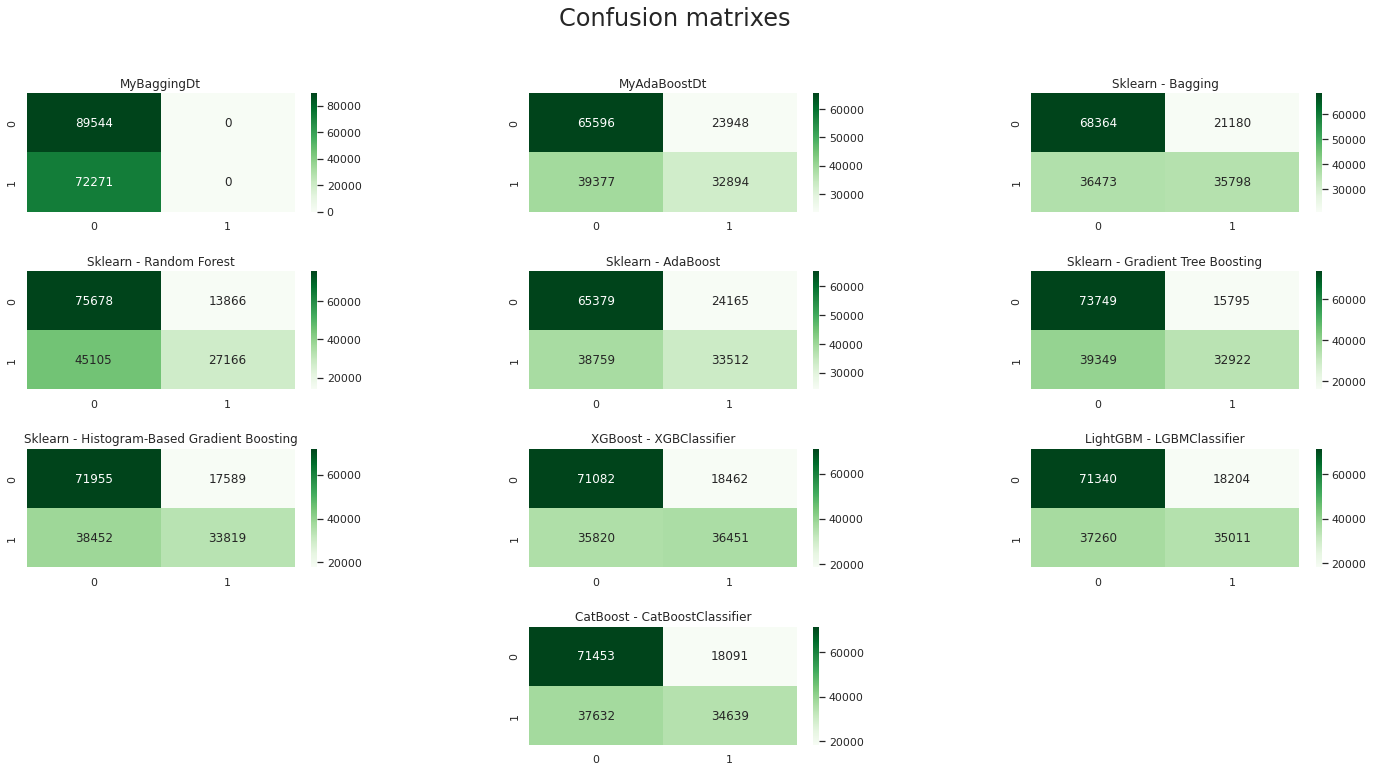

In [40]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(24, 12))

plt.suptitle("Confusion matrixes", fontsize = 24)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.subplot(4, 3, 1)
plt.title("MyBaggingDt")
sns.heatmap(confusion_matrix(y_test, bagging_pred), cmap='Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 2)
plt.title("MyAdaBoostDt")
sns.heatmap(confusion_matrix(y_test, adaboost_pred), cmap='Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 3)
plt.title("Sklearn - Bagging")
sns.heatmap(confusion_matrix(y_test, sklearn_bagging_pred), cmap='Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 4)
plt.title("Sklearn - Random Forest")
sns.heatmap(confusion_matrix(y_test, sklearn_rfc_pred), cmap = 'Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 5)
plt.title("Sklearn - AdaBoost")
sns.heatmap(confusion_matrix(y_test, sklearn_adaboost_pred), cmap = 'Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 6)
plt.title("Sklearn - Gradient Tree Boosting")
sns.heatmap(confusion_matrix(y_test, sklearn_gbc_pred), cmap = 'Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 7)
plt.title("Sklearn - Histogram-Based Gradient Boosting")
sns.heatmap(confusion_matrix(y_test, sklearn_hgbc_pred), cmap = 'Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 8)
plt.title("XGBoost - XGBClassifier")
sns.heatmap(confusion_matrix(y_test, xgbc_pred), cmap = 'Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 9)
plt.title("LightGBM - LGBMClassifier")
sns.heatmap(confusion_matrix(y_test, lgbmc_pred), cmap = 'Greens', annot = True, fmt = 'd')

plt.subplot(4, 3, 11)
plt.title("CatBoost - CatBoostClassifier")
sns.heatmap(confusion_matrix(y_test, cbc_pred), cmap = 'Greens', annot = True, fmt = 'd')

plt.show()

- Реализация AdaBoost показывает сходные с библиотечной реализацией результаты.
- Реализациия Bagging предсказывает больше True Negative, чем другие алгоритмы, при этом не предсказывает True Positive, сильно теряя в точности в сравнении с другими моделями. 
- Библиотечные реализации показали сходные друг с другом результаты.